# Q-Learning

In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../../modules')

import json

import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from env.gridworld import GridWorldWithWallsAndTraps
from policy import EpsilonGreedyPolicy
from algo.td import OneStepTDControl

In [4]:
nrows, ncols = 5, 15

In [7]:
grid_type_array = pd.read_csv("../grid_type_arrays/cliff.csv").fillna(0).to_numpy()[:nrows, 1:ncols+1]

In [8]:
grid_type_array

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4.]])

In [14]:
# env = GridWorldWithWallsAndTraps(grid_type_array, trap_reward=-100)
# policy = EpsilonGreedyPolicy(q=np.zeros(env.action_space_shape), epsilon=0.1)

# algo = OneStepTDControl(
#     env=env, policy=policy, 
#     mode='qlearning', alpha=0.1
# )

# returns = algo.run(max_iterations=10000, which_tqdm='notebook')

In [15]:
# np.save('qlearning_learned_q.npy', algo.q)
# np.save('qlearning_num_updates.npy', algo.num_updates)
# np.save('qlearning_online_returns.npy', np.array(returns))

In [16]:
env = GridWorldWithWallsAndTraps(grid_type_array, trap_reward=-100)
policy = EpsilonGreedyPolicy(q=np.load('qlearning_learned_q.npy'), epsilon=0.1)

algo = OneStepTDControl(
    env=env, policy=policy, 
    mode='sarsa', alpha=0.1
)

returns = np.load('qlearning_online_returns.npy')
num_updates = np.load('qlearning_num_updates.npy')

In [17]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

## Learning curve / online performance

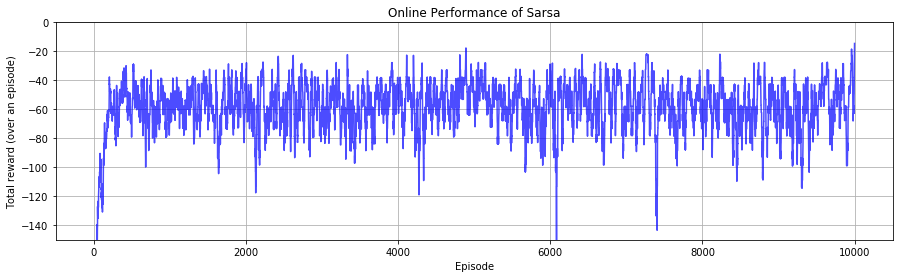

In [18]:
plt.figure(figsize=(15, 4))

plt.plot(smooth(returns, 20), alpha=0.7, color='blue')

plt.ylim(-150, 0)
plt.grid()

plt.title('Online Performance of Sarsa')
plt.xlabel('Episode'); plt.ylabel('Total reward (over an episode)')

plt.show()

## Number of updates for each state

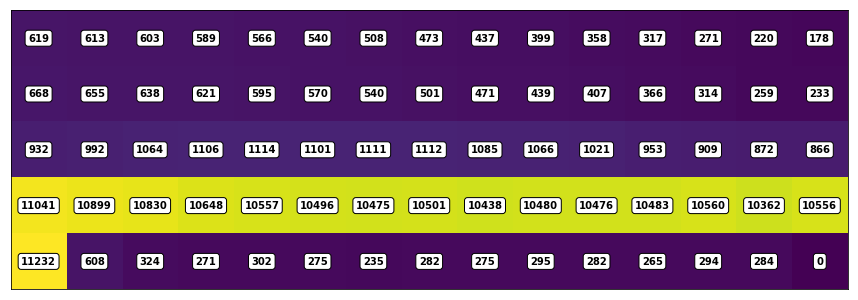

In [19]:
plt.figure(figsize=(15, 7))
num_updates_per_state = num_updates.sum(axis=-1)
plt.matshow(num_updates_per_state, fignum=1)
for (i, j), z in np.ndenumerate(num_updates_per_state):
    plt.text(
        j, i, int(z),
        ha='center', va='center', color='black', fontsize=10, weight='bold',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0')
    )
plt.xticks([]); plt.yticks([])
plt.show()

## Learned greedy policy

In [20]:
greedy_traj = algo.sample_greedy_trajectory()
len(greedy_traj)

17

In [21]:
learned_policy = algo.q.argmax(axis=-1)

In [22]:
optimal_policy = np.load('optimal_policy_for_greedy_policy.npy')

In [23]:
ix_to_str = {
    0 : r'$\uparrow$',
    1 : r'$\rightarrow$',
    2 : r'$\downarrow$',
    3 : r'$\leftarrow$'
}

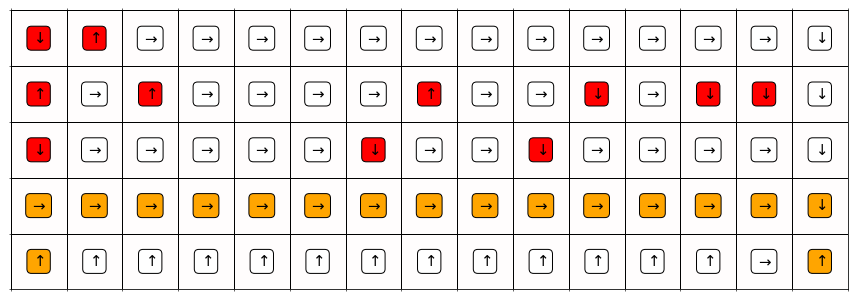

In [24]:
plt.figure(figsize=(15, 7))

plt.matshow(np.zeros_like(learned_policy), fignum=1, vmin=-1, vmax=1, cmap='seismic')

for (i, j), z in np.ndenumerate(learned_policy):

    if (i, j) in greedy_traj:
        facecolor='orange'
    else:
        facecolor='white'
        
    if z != optimal_policy[i, j]:
        facecolor='red'
        
    plt.text(
        j, i, ix_to_str[int(z)], 
        ha='center', va='center', color='black', fontsize=15, weight='bold',
        bbox=dict(boxstyle='round', facecolor=facecolor, edgecolor='0')
    )

plt.xticks([]); plt.yticks([])

ax = plt.gca()
ax.set_xticks(np.arange(-.5, 15, 1), minor=True);
ax.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
plt.show()